In [2]:
# Imports
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import minmax_scale

import re

In [3]:
# Read the FBI crime data into a Pandas dataframe
url = "https://raw.githubusercontent.com/Lambda-School-Labs/cityspire-d-ds/data-persist-crime-data/notebooks/data/ucr_fbi_gov_crime_city_2019.csv"
df_crime = pd.read_csv(url)
df_crime

,state,city,population,violent_crime,murder_nonnegligent_manslaughter,rape,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,state_abbr
0,ALABAMA,Hoover,85670.0,114.0,4.0,15.0,27.0,68.0,1922.0,128.0,1694.0,100.0,2.0,AL
1,ALASKA,Anchorage,287731.0,3581.0,32.0,540.0,621.0,2388.0,12261.0,1692.0,9038.0,1531.0,93.0,AK
2,ALASKA,Bethel,6544.0,130.0,1.0,47.0,3.0,79.0,132.0,20.0,84.0,28.0,12.0,AK
3,ALASKA,Bristol Bay Borough,852.0,2.0,0.0,0.0,0.0,2.0,20.0,5.0,8.0,7.0,0.0,AK
4,ALASKA,Cordova,2150.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,6.0,0.0,0.0,AK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8100,WYOMING,Sheridan,17895.0,9.0,0.0,4.0,0.0,5.0,369.0,75.0,278.0,16.0,3.0,WY
8101,WYOMING,Thermopolis,2830.0,13.0,0.0,0.0,0.0,13.0,34.0,7.0,22.0,5.0,0.0,WY
8102,WYOMING,Torrington,6709.0,13.0,0.0,4.0,1.0,8.0,48.0,8.0,40.0,0.0,0.0,WY
8103,WYOMING,Wheatland,3544.0,7.0,0.0,1.0,0.0,6.0,72.0,24.0,45.0,3.0,0.0,WY


In [4]:
df_crime.columns

Index(['state', 'city', 'population', 'violent_crime',
       'murder_nonnegligent_manslaughter', 'rape', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'arson', 'state_abbr'],
      dtype='object')

In [5]:
df_crime_srt = df_crime.sort_values('population', ascending=False)
df_crime_srt.reset_index(inplace=True, drop=True)
df_crime_srt

,state,city,population,violent_crime,murder_nonnegligent_manslaughter,rape,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,state_abbr
0,NEW YORK,New York,8379043.0,47821.0,319.0,2770.0,13396.0,31336.0,122299.0,9846.0,106931.0,5522.0,NaN,NY
1,CALIFORNIA,Los Angeles,4015546.0,29400.0,258.0,2274.0,9652.0,17216.0,95704.0,13809.0,66253.0,15642.0,1672.0,CA
2,ILLINOIS,Chicago,2707064.0,25532.0,492.0,1761.0,7983.0,15296.0,80742.0,9578.0,62083.0,9081.0,416.0,IL
3,TEXAS,Houston,2355606.0,25257.0,275.0,1249.0,9147.0,14586.0,101750.0,17038.0,71614.0,13098.0,485.0,TX
4,ARIZONA,Phoenix,1688722.0,11803.0,131.0,1139.0,3197.0,7336.0,55974.0,9471.0,39427.0,7076.0,201.0,AZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8100,NEW JERSEY,Pine Valley,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NJ
8101,COLORADO,Lakeside,8.0,0.0,0.0,0.0,0.0,0.0,205.0,1.0,202.0,2.0,0.0,CO
8102,NEW JERSEY,Tavistock,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NJ
8103,MARYLAND,Baltimore City Sheriff,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MD


In [6]:
# Focus on the Top 100 cities by population
df_crime_top = df_crime_srt.head(100).copy()
df_crime_top.head(10)

,state,city,population,violent_crime,murder_nonnegligent_manslaughter,rape,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,state_abbr
0,NEW YORK,New York,8379043.0,47821.0,319.0,2770.0,13396.0,31336.0,122299.0,9846.0,106931.0,5522.0,NaN,NY
1,CALIFORNIA,Los Angeles,4015546.0,29400.0,258.0,2274.0,9652.0,17216.0,95704.0,13809.0,66253.0,15642.0,1672.0,CA
2,ILLINOIS,Chicago,2707064.0,25532.0,492.0,1761.0,7983.0,15296.0,80742.0,9578.0,62083.0,9081.0,416.0,IL
3,TEXAS,Houston,2355606.0,25257.0,275.0,1249.0,9147.0,14586.0,101750.0,17038.0,71614.0,13098.0,485.0,TX
4,ARIZONA,Phoenix,1688722.0,11803.0,131.0,1139.0,3197.0,7336.0,55974.0,9471.0,39427.0,7076.0,201.0,AZ
5,NEVADA,Las Vegas Metropolitan Police Department,1666803.0,8854.0,84.0,1439.0,2118.0,5213.0,46197.0,10646.0,28240.0,7311.0,125.0,NV
6,TEXAS,San Antonio,1559166.0,11046.0,105.0,1630.0,1965.0,7346.0,67422.0,8172.0,51469.0,7781.0,181.0,TX
7,CALIFORNIA,San Diego,1441737.0,5215.0,50.0,561.0,1346.0,3258.0,27141.0,3543.0,18426.0,5172.0,122.0,CA
8,TEXAS,Dallas,1363295.0,11764.0,198.0,797.0,4400.0,6369.0,45279.0,9210.0,25812.0,10257.0,144.0,TX
9,CALIFORNIA,San Jose,1040008.0,4559.0,32.0,671.0,1339.0,2517.0,25164.0,4114.0,14924.0,6126.0,135.0,CA


In [7]:
# NOTE: Some property crime values are missing. Need to substitute reasonable property crimes values
# Generate a dataframe without rows that include missing the property crimes value
df_rmv_missing_prop_crimes = df_crime_top.copy()
df_rmv_missing_prop_crimes.dropna(subset=['property_crime'], inplace=True)

print(f"NOTE: {len(df_crime_top)-len(df_rmv_missing_prop_crimes)} rows have been removed because they don't have property_crime values\n")

# Add a "decile_rank" column to: df_rmv_missing_prop_crimes
df_rmv_missing_prop_crimes['decile_rank'] = pd.qcut(df_rmv_missing_prop_crimes['population'],
                                                    q = 10, 
                                                    labels = False)
df_rmv_missing_prop_crimes

NOTE: 2 rows have been removed because they don't have property_crime values



,state,city,population,violent_crime,murder_nonnegligent_manslaughter,rape,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,state_abbr,decile_rank
0,NEW YORK,New York,8379043.0,47821.0,319.0,2770.0,13396.0,31336.0,122299.0,9846.0,106931.0,5522.0,NaN,NY,9
1,CALIFORNIA,Los Angeles,4015546.0,29400.0,258.0,2274.0,9652.0,17216.0,95704.0,13809.0,66253.0,15642.0,1672.0,CA,9
2,ILLINOIS,Chicago,2707064.0,25532.0,492.0,1761.0,7983.0,15296.0,80742.0,9578.0,62083.0,9081.0,416.0,IL,9
3,TEXAS,Houston,2355606.0,25257.0,275.0,1249.0,9147.0,14586.0,101750.0,17038.0,71614.0,13098.0,485.0,TX,9
4,ARIZONA,Phoenix,1688722.0,11803.0,131.0,1139.0,3197.0,7336.0,55974.0,9471.0,39427.0,7076.0,201.0,AZ,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,IOWA,Des Moines,218384.0,1555.0,14.0,117.0,283.0,1141.0,8933.0,2284.0,5336.0,1313.0,53.0,IA,0
96,CALIFORNIA,Santa Clarita,218103.0,277.0,2.0,49.0,89.0,137.0,2059.0,392.0,1448.0,219.0,17.0,CA,0
97,CALIFORNIA,San Bernardino,216715.0,2858.0,46.0,140.0,906.0,1766.0,9081.0,2029.0,4974.0,2078.0,75.0,CA,0
98,CALIFORNIA,Modesto,216542.0,1758.0,13.0,94.0,399.0,1252.0,7183.0,1149.0,4849.0,1185.0,95.0,CA,0


In [8]:
# Add a "decile_rank" column to: df_crime_top
df_crime_top['decile_rank'] = pd.qcut(df_crime_top['population'],
                                      q = 10, 
                                      labels = False)

df_crime_top

,state,city,population,violent_crime,murder_nonnegligent_manslaughter,rape,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,state_abbr,decile_rank
0,NEW YORK,New York,8379043.0,47821.0,319.0,2770.0,13396.0,31336.0,122299.0,9846.0,106931.0,5522.0,NaN,NY,9
1,CALIFORNIA,Los Angeles,4015546.0,29400.0,258.0,2274.0,9652.0,17216.0,95704.0,13809.0,66253.0,15642.0,1672.0,CA,9
2,ILLINOIS,Chicago,2707064.0,25532.0,492.0,1761.0,7983.0,15296.0,80742.0,9578.0,62083.0,9081.0,416.0,IL,9
3,TEXAS,Houston,2355606.0,25257.0,275.0,1249.0,9147.0,14586.0,101750.0,17038.0,71614.0,13098.0,485.0,TX,9
4,ARIZONA,Phoenix,1688722.0,11803.0,131.0,1139.0,3197.0,7336.0,55974.0,9471.0,39427.0,7076.0,201.0,AZ,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,IOWA,Des Moines,218384.0,1555.0,14.0,117.0,283.0,1141.0,8933.0,2284.0,5336.0,1313.0,53.0,IA,0
96,CALIFORNIA,Santa Clarita,218103.0,277.0,2.0,49.0,89.0,137.0,2059.0,392.0,1448.0,219.0,17.0,CA,0
97,CALIFORNIA,San Bernardino,216715.0,2858.0,46.0,140.0,906.0,1766.0,9081.0,2029.0,4974.0,2078.0,75.0,CA,0
98,CALIFORNIA,Modesto,216542.0,1758.0,13.0,94.0,399.0,1252.0,7183.0,1149.0,4849.0,1185.0,95.0,CA,0


In [9]:
# Fill in reasonable values for cities with missing property crime data
def gen_prop_crim_val(recrd):
  """
  gen_prop_crim_val returns a generated property crime value
  if the input property crime value (val) is missing.

  parameters:
    - p_val:   the property crime value for the current record
    - v_val:   the violent crime value for the current record
    - dec_val: the population decile value for the current record
  """
  # Fetch values from the inbound record
  p_val   = recrd[8]
  v_val   = recrd[3]
  dec_val = recrd[14]

  # is the current property value "missing"?
  if not math.isnan(p_val):
    # a value exists -> just return the value
    return p_val

  # the current value is missing (not a number); return a proxy value

  # generate a temp dataframe that only includes the decile value equal
  # to the passed record
  df_tmp = df_rmv_missing_prop_crimes[df_rmv_missing_prop_crimes['decile_rank']==dec_val]

  # cut down the dataframe to 'violent_crime' and 'property_crime'
  cols_keep = ['violent_crime', 'property_crime']
  df_tmp = df_tmp[cols_keep]

  # generate a return proxy value that is equal to:
  #   the current record's violent crime rate * the current decile's 
  #   property crime to violent crime ratio
  return round(df_tmp['property_crime'].sum() / df_tmp['violent_crime'].sum() * v_val,
               0)
  

In [10]:
# Fill in missing property crime data with proxy values
# Apply 
temp_value = df_crime_top.apply(gen_prop_crim_val, axis=1) 

df_crime_top['property_crime_upd'] = temp_value

df_crime_top[['property_crime', 'property_crime_upd']]

,property_crime,property_crime_upd
0,122299.0,122299.0
1,95704.0,95704.0
2,80742.0,80742.0
3,101750.0,101750.0
4,55974.0,55974.0
...,...,...
95,8933.0,8933.0
96,2059.0,2059.0
97,9081.0,9081.0
98,7183.0,7183.0


In [11]:
# Add two new columns/features
#   1. Violent Crime Rate Per  100,000: violent_crime  / population * 100000
#   2. Property Crime Rate Per 100,000: property_crime / population * 100000
def gen_rate(ncrm, pop):
  """
  gen_rate calculates crime rates per 100k in population given
  the number of crimes and the locale's population
  """
  return ncrm/pop*100000

# Calculate the violent and property crime rates
df_crime_top['violent_crime_rate']  = gen_rate(df_crime_top['violent_crime'], df_crime_top['population'])
df_crime_top['property_crime_rate'] = gen_rate(df_crime_top['property_crime_upd'], df_crime_top['population'])
df_crime_top[['violent_crime_rate', 'property_crime_rate']].describe()

,violent_crime_rate,property_crime_rate
count,100.000000,100.000000
mean,683.380732,3290.628103
std,416.828915,1312.883094
min,64.235512,944.049371
25%,373.112069,2149.219348
50%,601.327942,3289.993675
75%,863.108112,4154.021127
max,1965.329419,6775.697608


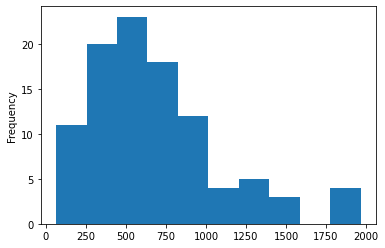

In [12]:
df_crime_top['violent_crime_rate'].plot.hist();

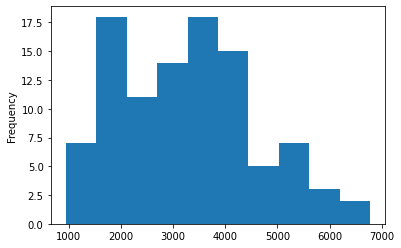

In [13]:
df_crime_top['property_crime_rate'].plot.hist();

In [14]:
df_crime_top.columns

Index(['state', 'city', 'population', 'violent_crime',
       'murder_nonnegligent_manslaughter', 'rape', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'arson', 'state_abbr', 'decile_rank',
       'property_crime_upd', 'violent_crime_rate', 'property_crime_rate'],
      dtype='object')

In [15]:
# Calculate a weighted average of the violent and property crime rates
wgt_v = 0.8 # weight of the violent crime rate
wgt_p = 0.2 # weight of the property crime rate

def gen_wgt_avg(rcrd):
  """
  gen_wgt_avg returns the weighted average of the violent crime
  and property crime rates
  """
  return np.average([rcrd[16], rcrd[17]], weights=[wgt_v, wgt_p])

df_crime_top['combined_weighted_crime_rate'] = df_crime_top.apply(gen_wgt_avg, axis=1)


In [16]:
df_crime_top[['violent_crime_rate', 'property_crime_rate', 'combined_weighted_crime_rate']].sample(10)

,violent_crime_rate,property_crime_rate,combined_weighted_crime_rate
33,627.123327,3182.120661,1138.122794
91,462.896745,3499.464721,1070.210341
68,729.979092,3807.593781,1345.502030
98,811.851742,3317.139400,1312.909274
15,503.354964,3307.950382,1064.274048
83,863.704403,2035.588784,1098.081279
18,748.894629,3743.512849,1347.818273
12,739.414992,3925.825514,1376.697096
52,435.468016,2040.375947,756.449602
69,328.452567,1386.476765,540.057407


In [17]:
# Scaled the combined weighted crime rate across all cities
#   - rate will scale from 0 (least crime rate) to 1 (highest crime rate)
df_crime_top['combined_scaled_rate'] = minmax_scale(df_crime_top['combined_weighted_crime_rate'])

df_crime_top['combined_scaled_rate'].describe()

count    100.000000
mean       0.367517
std        0.221645
min        0.000000
25%        0.202742
50%        0.354758
75%        0.502693
max        1.000000
Name: combined_scaled_rate, dtype: float64

In [18]:
# Create column to be used to search on city names and converts 
#    formal city names (e.g. St. Louis) to a normalized version (st_louis)
#      - lowercase all alpha characters
#      - convert spaces to underscores ("_")
#      - remove all other characters which are not alpha characters or underscores (e.g. ".")
def norm_city_names(cty):
  if len(cty) == 0:
    return cty

  # transform cty to lowercase
  cty = cty.lower()
  # replace whitespace with underscores ("_")
  cty = re.sub("\s", "_", cty)
  # remove all other characters (ie. not alpha or underscore characters)
  cty = re.sub("[^a-z\_]", "", cty)

  return cty


In [19]:
# Add a column of "normalized" city names
df_crime_top['city_norm'] = df_crime_top['city'].apply(norm_city_names)
df_crime_top

,state,city,population,violent_crime,murder_nonnegligent_manslaughter,rape,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,state_abbr,decile_rank,property_crime_upd,violent_crime_rate,property_crime_rate,combined_weighted_crime_rate,combined_scaled_rate,city_norm
0,NEW YORK,New York,8379043.0,47821.0,319.0,2770.0,13396.0,31336.0,122299.0,9846.0,106931.0,5522.0,NaN,NY,9,122299.0,570.721501,1459.581959,748.493593,0.184109,new_york
1,CALIFORNIA,Los Angeles,4015546.0,29400.0,258.0,2274.0,9652.0,17216.0,95704.0,13809.0,66253.0,15642.0,1672.0,CA,9,95704.0,732.154482,2383.337160,1062.391017,0.310269,los_angeles
2,ILLINOIS,Chicago,2707064.0,25532.0,492.0,1761.0,7983.0,15296.0,80742.0,9578.0,62083.0,9081.0,416.0,IL,9,80742.0,943.162038,2982.640972,1351.057825,0.426288,chicago
3,TEXAS,Houston,2355606.0,25257.0,275.0,1249.0,9147.0,14586.0,101750.0,17038.0,71614.0,13098.0,485.0,TX,9,101750.0,1072.208171,4319.482970,1721.663130,0.575239,houston
4,ARIZONA,Phoenix,1688722.0,11803.0,131.0,1139.0,3197.0,7336.0,55974.0,9471.0,39427.0,7076.0,201.0,AZ,9,55974.0,698.930908,3314.577533,1222.060233,0.374442,phoenix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,IOWA,Des Moines,218384.0,1555.0,14.0,117.0,283.0,1141.0,8933.0,2284.0,5336.0,1313.0,53.0,IA,0,8933.0,712.048502,4090.501136,1387.739029,0.441031,des_moines
96,CALIFORNIA,Santa Clarita,218103.0,277.0,2.0,49.0,89.0,137.0,2059.0,392.0,1448.0,219.0,17.0,CA,0,2059.0,127.004214,944.049371,290.413245,0.000000,santa_clarita
97,CALIFORNIA,San Bernardino,216715.0,2858.0,46.0,140.0,906.0,1766.0,9081.0,2029.0,4974.0,2078.0,75.0,CA,0,9081.0,1318.782733,4190.296011,1893.085389,0.644136,san_bernardino
98,CALIFORNIA,Modesto,216542.0,1758.0,13.0,94.0,399.0,1252.0,7183.0,1149.0,4849.0,1185.0,95.0,CA,0,7183.0,811.851742,3317.139400,1312.909274,0.410955,modesto


In [21]:
# Export data to be imported into the database
cols_export = [
  'state',
  'city',
  'population',
  'violent_crime',
  'murder_nonnegligent_manslaughter',
  'rape',
  'robbery',
  'aggravated_assault',
  'property_crime',
  'burglary',
  'larceny_theft',
  'motor_vehicle_theft',
  'arson',
  'state_abbr',
  'combined_scaled_rate',
  'city_norm']

from google.colab import files
df_crime_top[cols_export].to_csv('df_crime_top.csv')
files.download('df_crime_top.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>